<a href="https://colab.research.google.com/github/NadezhdaGruzdeva/A-B-testing/blob/main/HW9_Mobile_Games_A_B_Testing_Cookie_Cats_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful links
kaggle https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats  
lecture https://gb.ru/lessons/316636  
dataset  https://docs.google.com/spreadsheets/d/10DM_ZqwV6CvOryD6u3pYHb5scjEfiwfkitUGTCG8l7Y/edit?usp=sharing  
plotly https://habr.com/ru/articles/502958/

#About Dataset  
<image src="https://storage.googleapis.com/kaggle-datasets-images/1149830/1927698/d7540e40aa0a376303e9f67f7a53a114/dataset-cover.png?t=2021-02-12-19-18-59" alt="game pct">
##Context  
This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.  

##Content  
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:  

userid: A unique number that identifies each player.  
version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.  
retention_1: Did the player come back and play 1 day after installing?  
retention_7: Did the player come back and play 7 days after installing?  

When a player installed the game, he or she was randomly assigned to either.  

##Acknowledgements  
This dataset is taken from DataCamp  
Cookie Cat is a hugely popular mobile puzzle game developed by Tactile Entertainment  
  
Thanks to them for this dataset! 😻

##Cookie Cats and Project Goal

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.



As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.



But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.

#  Libraries import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_1samp, mannwhitneyu, shapiro, norm, t, kstest, shapiro
from statsmodels.stats.power import TTestIndPower # estimate sample size via power analysis
from statsmodels.stats import proportion
import plotly.express as px # Интерактивная библиотека для графиков.
import math
import statsmodels.stats.power as smp


In [ ]:
SHEET_ID = '10DM_ZqwV6CvOryD6u3pYHb5scjEfiwfkitUGTCG8l7Y'
SHEET_NAME = 'AAPL'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url,decimal=',')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


# 1. Descriptive statistics

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [ ]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [ ]:
df.describe(include = 'object')

,version
count,90189
unique,2
top,gate_40
freq,45489


---
Dataset does not have any null data   
The freq is the most common value’s frequency = 45.489 (approcimately 50% of total for both groups)

---

# 2. Check if there are duplicated ID

In [ ]:
df['userid'].nunique() == df['userid'].count()

True

--- 
There is no any duplicated ID

---

##3. Quick comparison of 2 groups

In [ ]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


In [ ]:
df_c = df[df['version'] == 'gate_30']
df_t = df[df['version'] == 'gate_40']

In [ ]:
#calc of difference of retentionin between 2 groups
ret1_dif = (df_c.describe(include='all').loc['mean']['retention_1'] - df_t.describe(include='all').loc['mean']['retention_1']) / df_t.describe(include='all').loc['mean']['retention_1']
ret7_dif = (df_c.describe(include='all').loc['mean']['retention_7'] - df_t.describe(include='all').loc['mean']['retention_7']) / df_t.describe(include='all').loc['mean']['retention_7']
ret1_dif, ret7_dif

(0.013351571571965584, 0.04506206776910276)

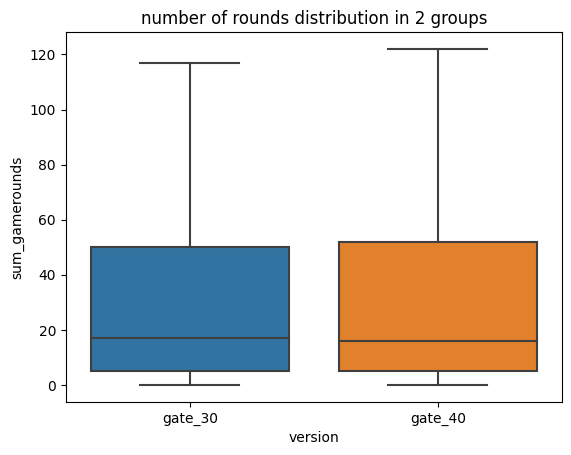

In [ ]:
sns.boxplot(x=df['version'], y=df['sum_gamerounds'], showfliers = False)
plt.title('number of rounds distribution in 2 groups'); 

---
At the first glance there is   
- no significant difference between average number of rounds between 2 groups. 
- retention of control group (gate 30) is highter that retantion of treatment group (gate 40).   
In both case: 1day and 7 day on 1.3% and 4.5% accordingly

---


Let's check it statisticly.

#4. Checking if distribution of sum_gamerounds by users is normal or not

In [ ]:
fig = px.histogram(df['sum_gamerounds'][df['sum_gamerounds']< 100], marginal = 'box')
fig.update_layout(xaxis_title="gamerounds per user",
                  yaxis_title="users",
                  title="Distribution of game rounds",
                  showlegend=False)
fig.show(renderer='colab')
# legend_orientation="h", 
#                   margin=dict(l=0, r=0, t=0, b=0)

--- 
This distribution doesn't look like normal one.  
For additional practice let's check it using statistical test (Kolmogorov-Smirnov or Shapiro).  
Shapiro test is the best test for sample size > 5000.
Or sample size =  90189.  
So let's use Kolmogorov-Smirnov test

----


Тест Колмогорова-Смирнова - проверка на нормальность.

Для выборок любого размера.

$H_0$ - x взята из генеральной совокупности с нормальным распределением.

$H_1$ - x взята из ген.совокупности с другим распределением.

Можно использовать для проверки любого другого распределения(Стьюдента, биномиального, коши, экспоненциального).

**При p-value > alpha: анализируемое распределение не отличается от нормального.**


In [ ]:
# Проверим принадлежность выборок к нормальному распределению.

print(kstest(df['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.8715607041848303, pvalue=0.0, statistic_location=2, statistic_sign=-1)


---
P-value is too low, distribution isn't normal. 

---




#5. Checking statistical diiferense of averege sum_gamerounds

In [ ]:
mannwhitneyu(x=df_c['sum_gamerounds'].values,y=df_t['sum_gamerounds'].values)

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)


---

p-value> alpha (0.5) So we don't reject H0 hypothesis and accept that there is no significant difference of sum_gamerounds between 2 groups

---

#6. Checking statistical diiferense of retention_1

##6.1. Test for proportion

In [ ]:
k1 = df_t['retention_1'].sum()
k2 = df_c['retention_1'].sum()
k1, k2

(20119, 20034)

In [ ]:
n1 = df_t.shape[0]
n2 = df_c.shape[0]
n1,n2

(45489, 44700)

In [ ]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =-1.784, pvalue = 0.074


In [ ]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


##6.2. Chi-squared test (Непараметрический Хи-квадрат)

In [ ]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =3.183, pvalue = 0.074


In [ ]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


---

Both test show same p-value (0.074).  
We can accept that there is no significant difference of retention_1 between 2 groups

---

#7. Checking statistical diiferense of retention_7

Test for proportion

In [ ]:
k1 = df_t['retention_7'].sum()
k2 = df_c['retention_7'].sum()
k1, k2

(8279, 8502)

In [ ]:
n1 = df_t.shape[0]
n2 = df_c.shape[0]
n1,n2

(45489, 44700)

In [ ]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =-3.164, pvalue = 0.002


In [ ]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We may reject the null hypothesis!


---
We can accept that there is significant difference of retention_7 between 2 groups.

---

# 8. What exactly retention_7 means?

In [ ]:
df[(df['retention_1'] == 0) & (df['retention_7'] == 1)]

,userid,version,sum_gamerounds,retention_1,retention_7
10,1842,gate_40,3,0,1
23,2729,gate_30,105,0,1
90,8788,gate_30,19,0,1
102,10200,gate_40,106,0,1
143,13429,gate_30,60,0,1
...,...,...,...,...,...
89967,9975174,gate_30,26,0,1
90044,9982773,gate_30,1,0,1
90046,9983040,gate_30,137,0,1
90156,9996093,gate_40,23,0,1


---
There are players with retention_7 and withowout retenttion_1  
It means that some users can bu unactive on the next day after game installation and will play the game on the 7th day.   
The retantion_1  = 0  for them  
and retantion_7 = 1

---

#9. Statistical power of A/B test

### Факторы, влияющие на мощность теста:
1) ***статистические:*** 
- Размер выбора(effect_size, ошибка 1 рода, ошибка 2 рода)
- Дисперсия (дисперсия частично зашита в effect_size => чем больше дисперсия, тем больше нам нужно наблюдений)

2) ***продуктовые:***
- Сезонность(недельная/месячная...)
- Метрика (тип метрики, окно закрытия метрики)



In [ ]:
# Критерий пропорций (для кликов, конверсий)

alpha = 0.05 # 
power = 0.9 #
n = df_retention_ab['userid'].min()             # Количество наблюдений.
p_x = df_t.describe(include='all').loc['mean']['retention_7']          # Конверсии.
p_y = df_c.describe(include='all').loc['mean']['retention_7']

In [ ]:
# effect_size

h = 2 * math.asin(np.sqrt(p_x)) - 2 * math.asin(np.sqrt(p_y))
h

-0.021074001016365917

# Test Procedure

If we assume that $P_1$ and $P_2$ represents the two proportions. The effect_size is represented as this difference:

$h = φ_1 - φ_2 $, where $φ = arcsine(\sqrt{P_i})$

In [ ]:
# Мощность критерия для выборки из n элементов, если effect_size = h, alpha = 5%

power = smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8830912109776261

---
Power is hight.   
We have large enought sample size to trust statistical results obtained above.

---

#10. Conclusions

--- 
Checking the diiferense between control and treatment groups we found out following conclusions:  
 1. (-) There is no significant statistical difference of average amount of rounds by users  
 2. (-) There is no significant statistical difference of retention_1. It doesn't matter how many gates (30 or 40). Users retention behaviour on the next day after installation is the same.  
 3. (+) There is significant statistical difference of retention_7. Users retention behaviour on the 7th day after installation is different. Users with gate 30 (control group) tend to play more ( by 4.5%) on the 7th day that users with gate 40 (treatment group).   

Maybe the behaviour of users on the 8th or 9th days wouldn't be the same like on 7th day.   
As I understood the most important metrics for game owner is total sum_game rounds. And retention_7 is one of the most influencing metric on the total sum_game rounds.  
According to this amount of information, it's not recommended to increase gate level.  
 
----